In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import (
    Sequential,
    layers,
    optimizers,
    losses,
    metrics,
    callbacks,
    regularizers,
)
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

2024-05-22 06:56:47.317003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 06:56:47.317125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 06:56:47.465983: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
WORK_DIR = '/kaggle/working/'
DATA_DIR = '/kaggle/input/emotion/dataset'

In [3]:
class DataTransformation:
    def __init__(self, config: dict) -> None:
        self.image_size = (
            config["image_height"],
            config["image_width"],
        )
        self.image_channels_expactation = config["image_channels_expectation"]
        self.class_names = []
        self.batch_size = config["batch_size"]

    def get_dataset(self, path: Path) -> tuple[tf.data.Dataset]:

        print(f"Loading dataset from: {path}")
        train_ds = tf.keras.utils.image_dataset_from_directory(
            path / "train",
            seed=242,
            image_size=self.image_size,
            batch_size=self.batch_size,
            shuffle=True,
            label_mode="categorical",
            color_mode="grayscale" if self.image_channels_expactation == 1 else "rgb",
        )
        val_ds = tf.keras.utils.image_dataset_from_directory(
            path / "test",
            seed=242,
            image_size=self.image_size,
            batch_size=self.batch_size,
            shuffle=True,
            label_mode="categorical",
            color_mode="grayscale" if self.image_channels_expactation == 1 else "rgb",
        )
        self.class_name = train_ds.class_names

        for image, label in train_ds:
            print(f"Batched image shape: {image.shape}")
            print(f"Batched label shape: {label.shape}")
            break

        AUTOTUNE = tf.data.AUTOTUNE
        train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
        val_ds = val_ds.map(lambda x, y: (rescaling(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
        return train_ds, val_ds

In [4]:
params = {
    "CNN": {
        "input_shape": [48, 48, 1],
        "num_classes": 6,
        "conv_units": [64, 128, 256],
        "dense_units": [1024],
        "dropout_rate": 0.1,
        "learning_rate": 1e-2,
        "l1": 0.001,
        "l2": 0.001,
    },

    "early_stopping": {
        "monitor": "val_loss", 
        "patience": 30
    },
    "reduce_lr": {
        "monitor": "val_loss",
        "patience": 1,
        "factor": 0.8,
        "min_lr": 1e-06,
    },
}

rescaling = layers.Rescaling(1.0 / 255)
data_augmentation = Sequential(
    [
        layers.Rescaling(1.0 / 255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)


early_stop = callbacks.EarlyStopping(
    monitor=params["early_stopping"]["monitor"],
    patience=params["early_stopping"]["patience"],
    verbose=1,
    mode="auto",
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor=params["reduce_lr"]["monitor"],
    factor=params["reduce_lr"]["factor"],
    patience=params["reduce_lr"]["patience"],
    min_lr=params["reduce_lr"]["min_lr"],
    mode="auto",
    verbose=1,
)


def evaluate_model(model: keras.Sequential, test_ds: tf.data.Dataset):
    result = model.evaluate(test_ds)
    print(f"Evaluating {model._name} model: {result}")

    y_pred = model.predict(test_ds)
    y_pred = y_pred.argmax(axis=1)

    y_true = test_ds.map(lambda x, y: y)
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()
    os.makedirs(name=f"visualize/{model._name}", exist_ok=True)
    plt.savefig(f"visualize/{model._name}/confusion_matrix.png")
    return result


def fit_model(
    model: keras.Sequential,
    train_ds: tf.data.Dataset,
    val_ds: tf.data.Dataset,
    epochs: int = 1000,
) -> callbacks.History:
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=[
            early_stop,
            reduce_lr,
            callbacks.ModelCheckpoint(
                filepath=f"{WORK_DIR}/weights/{model._name}/best.keras",
                monitor="val_f1_score",
                save_best_only=True,
                verbose=0,
            ),
            callbacks.ModelCheckpoint(
                filepath=f"{WORK_DIR}/weights/{model._name}/last.keras",
                monitor="val_loss",
                verbose=0,
            ),
            callbacks.CSVLogger(f'{WORK_DIR}/logs/{model._name}.log'),
        ],
    )
    return history


class CNN:
    def __init__(self, params) -> None:
        self.input_shape = params["input_shape"]
        self.num_classes = params["num_classes"]
        self.conv_units = params["conv_units"]
        self.dense_units = params["dense_units"]
        self.dropout_rate = params["dropout_rate"]
        self.initial_lr = params["learning_rate"]
        self.l1 = params["l1"]
        self.l2 = params["l2"]

    @property
    def build_model(self) -> Sequential:
        model = Sequential(name="CNN")
        model.add(layers.Input(self.input_shape))

        for units in self.conv_units:
            model.add(layers.Conv2D(units, (3, 3), padding="same", activation=keras.activations.leaky_relu))
            model.add(layers.BatchNormalization())
            model.add(layers.Conv2D(units, (3, 3), padding="same", activation=keras.activations.leaky_relu))
            model.add(layers.BatchNormalization())
            model.add(layers.MaxPooling2D(pool_size=2))
            model.add(layers.Dropout(self.dropout_rate))

        model.add(layers.Flatten())
        for units in self.dense_units:
            model.add(layers.Dense(units, activation=keras.activations.leaky_relu, kernel_regularizer=regularizers.l2(self.l2)))
            model.add(layers.Dropout(self.dropout_rate))

        model.add(layers.Dense(self.num_classes, activation="softmax", name="output"))

        model.compile(
            optimizer=optimizers.Adam(learning_rate=self.initial_lr),
            loss=losses.CategoricalCrossentropy(),
            metrics=[
                metrics.CategoricalAccuracy(),
                metrics.AUC(),
                metrics.Precision(),
                metrics.Recall(),
                metrics.F1Score(average="weighted"),
            ],
        )
        model._name = "CNN"
        print(f"{model._name} model summary: ")
        print(model.summary())
        os.makedirs(name=f"{WORK_DIR}/visualize/{model._name}", exist_ok=True)
        keras.utils.plot_model(
            model,
            to_file=f"{WORK_DIR}/visualize/{model._name}/layers_structure.png",
            show_shapes=True,
            show_layer_names=True,
        )
        return model

In [5]:
config = {
    "data_ingestion": {
        "data_path": DATA_DIR,
    },
    "data_transformation": {
        "image_width": 48,
        "image_height": 48,
        "image_channels_expectation": 1,
        "batch_size": 64,
    },
}

In [6]:
# Get dataset
data_transformation = DataTransformation(config=config["data_transformation"])
train_ds, val_ds = data_transformation.get_dataset(
    path=Path(config["data_ingestion"]["data_path"]),
)

Loading dataset from: /kaggle/input/emotion/dataset
Found 28273 files belonging to 6 classes.
Found 7067 files belonging to 6 classes.
Batched image shape: (64, 48, 48, 1)
Batched label shape: (64, 6)


In [7]:
# Create model
cnn = CNN(params=params["CNN"]).build_model

# Create directory for saving result training
os.makedirs(name=f'{WORK_DIR}/logs', exist_ok=True)
os.makedirs(name=f"visualize/{cnn._name}", exist_ok=True)

CNN model summary: 


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │         6,15

 Total params: 10,592,198 (40.41 MB)

 Trainable params: 10,590,406 (40.40 MB)

 Non-trainable params: 1,792 (7.00 KB)

None


In [8]:
# Train model
history = fit_model(model=cnn, train_ds=train_ds, val_ds=val_ds, epochs=1000)

Epoch 1/1000
  6/442 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - auc: 0.5233 - categorical_accuracy: 0.2059 - f1_score: 0.1915 - loss: 206.5330 - precision: 0.2271 - recall: 0.1931

I0000 00:00:1716361064.324993      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716361064.352192      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - auc: 0.5273 - categorical_accuracy: 0.1969 - f1_score: 0.1914 - loss: 42.6776 - precision: 0.1868 - recall: 0.1287

W0000 00:00:1716361099.874831      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716361102.286802      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716361109.397407      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


442/442 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - auc: 0.5274 - categorical_accuracy: 0.1969 - f1_score: 0.1915 - loss: 42.6151 - precision: 0.1868 - recall: 0.1285 - val_auc: 0.6104 - val_categorical_accuracy: 0.2444 - val_f1_score: 0.1688 - val_loss: 1.8218 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 2/1000
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.5997 - categorical_accuracy: 0.2504 - f1_score: 0.2110 - loss: 1.8274 - precision: 0.2634 - recall: 0.0031
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.
442/442 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - auc: 0.5997 - categorical_accuracy: 0.2504 - f1_score: 0.2110 - loss: 1.8274 - precision: 0.2634 - recall: 0.0031 - val_auc: 0.6251 - val_categorical_accuracy: 0.2783 - val_f1_score: 0.1779 - val_loss: 1.8488 - val_precision: 0.3316 - val_recall: 0.0535 - learning_rate: 0.0100
Epoch 3/1000
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.6019 - categorical_accuracy: 0.245

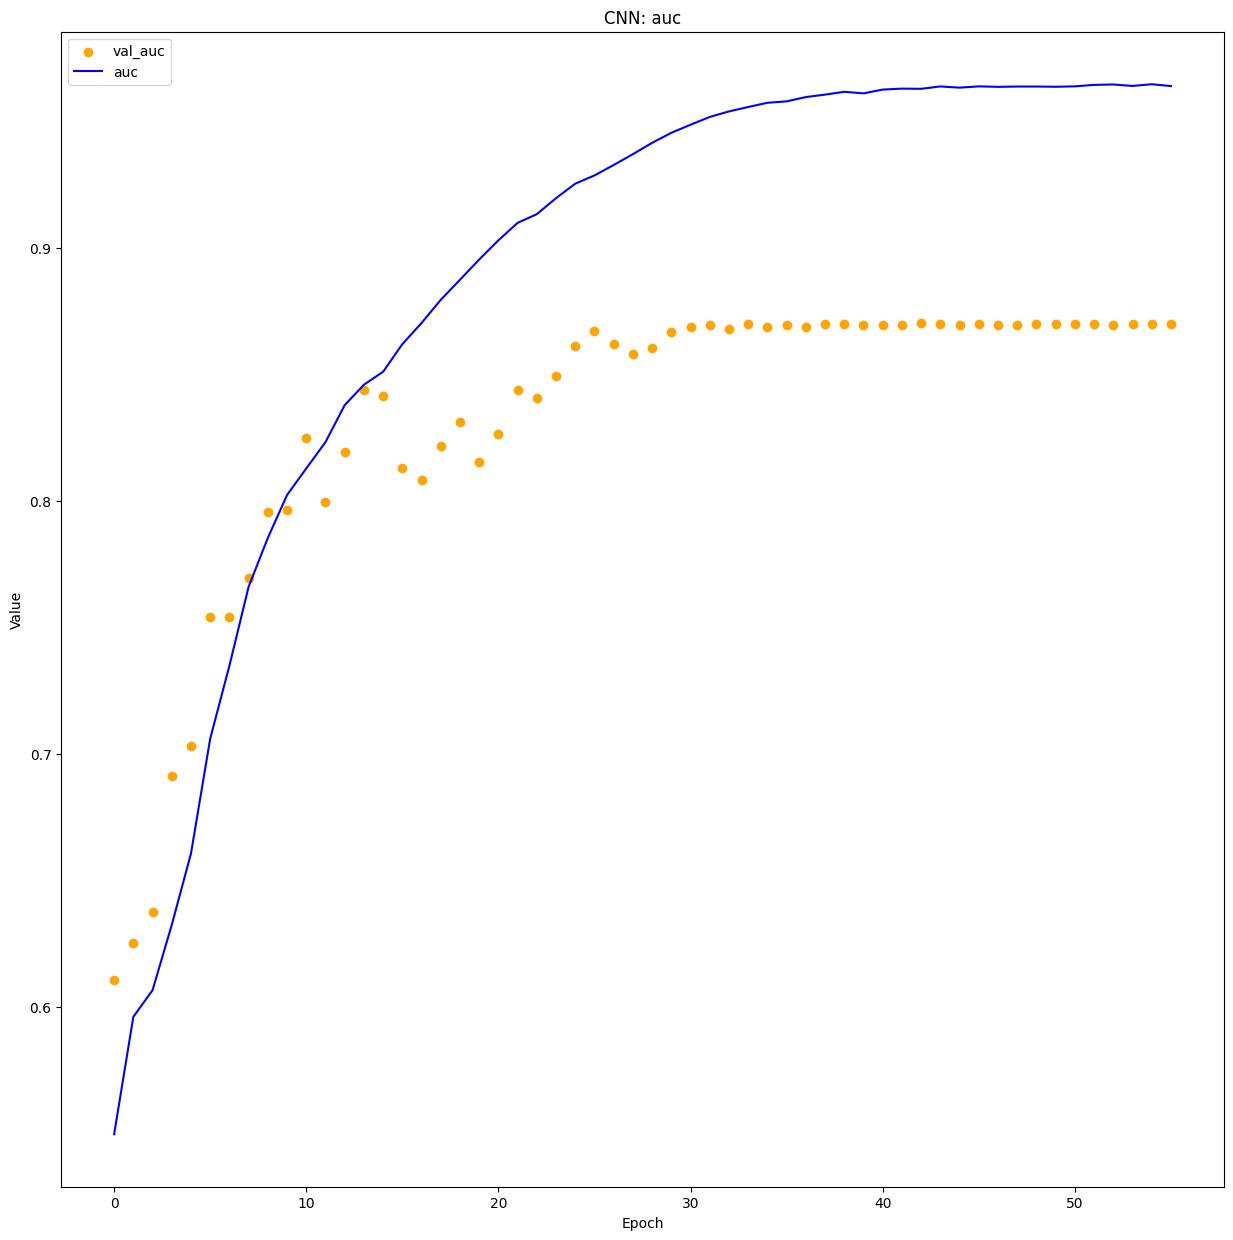

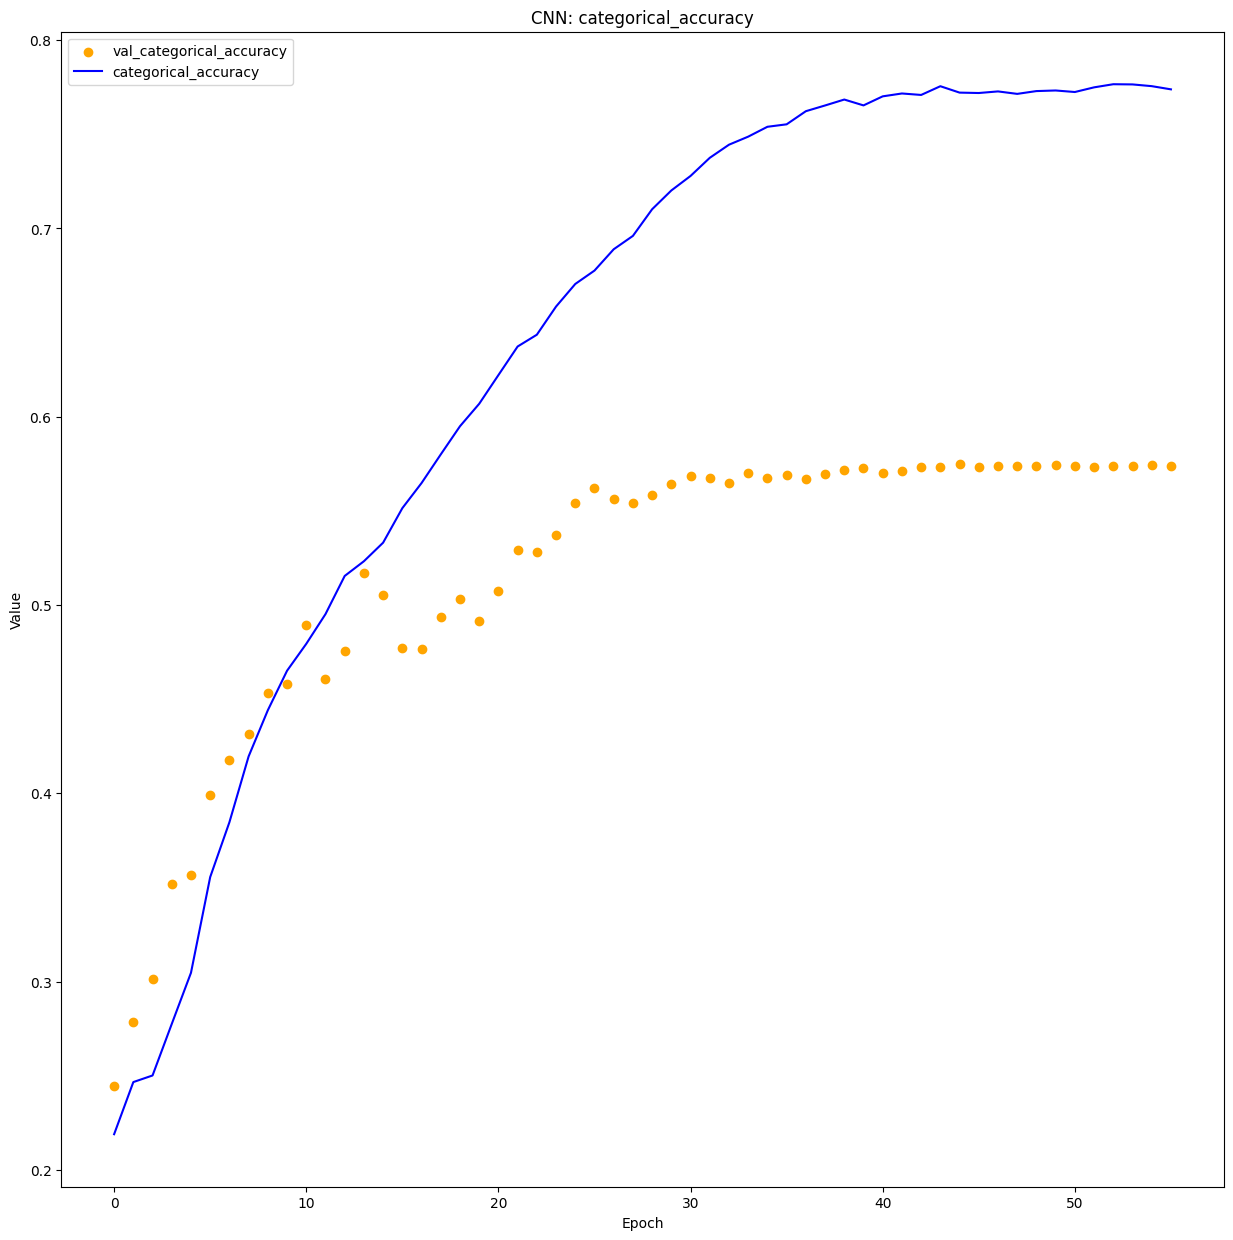

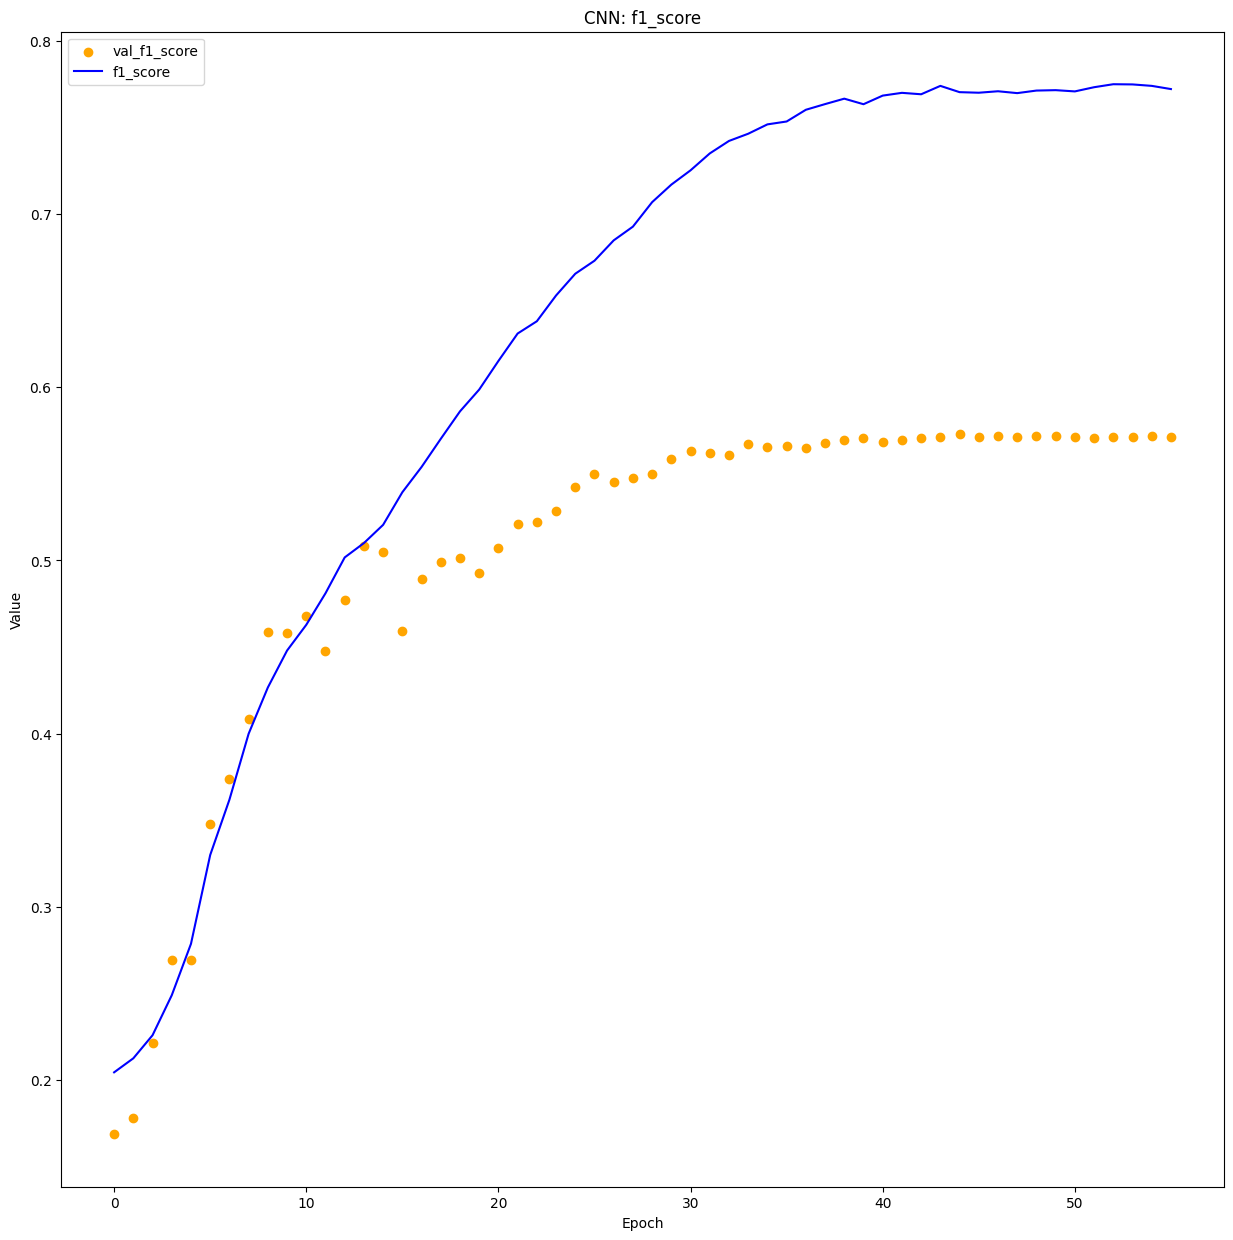

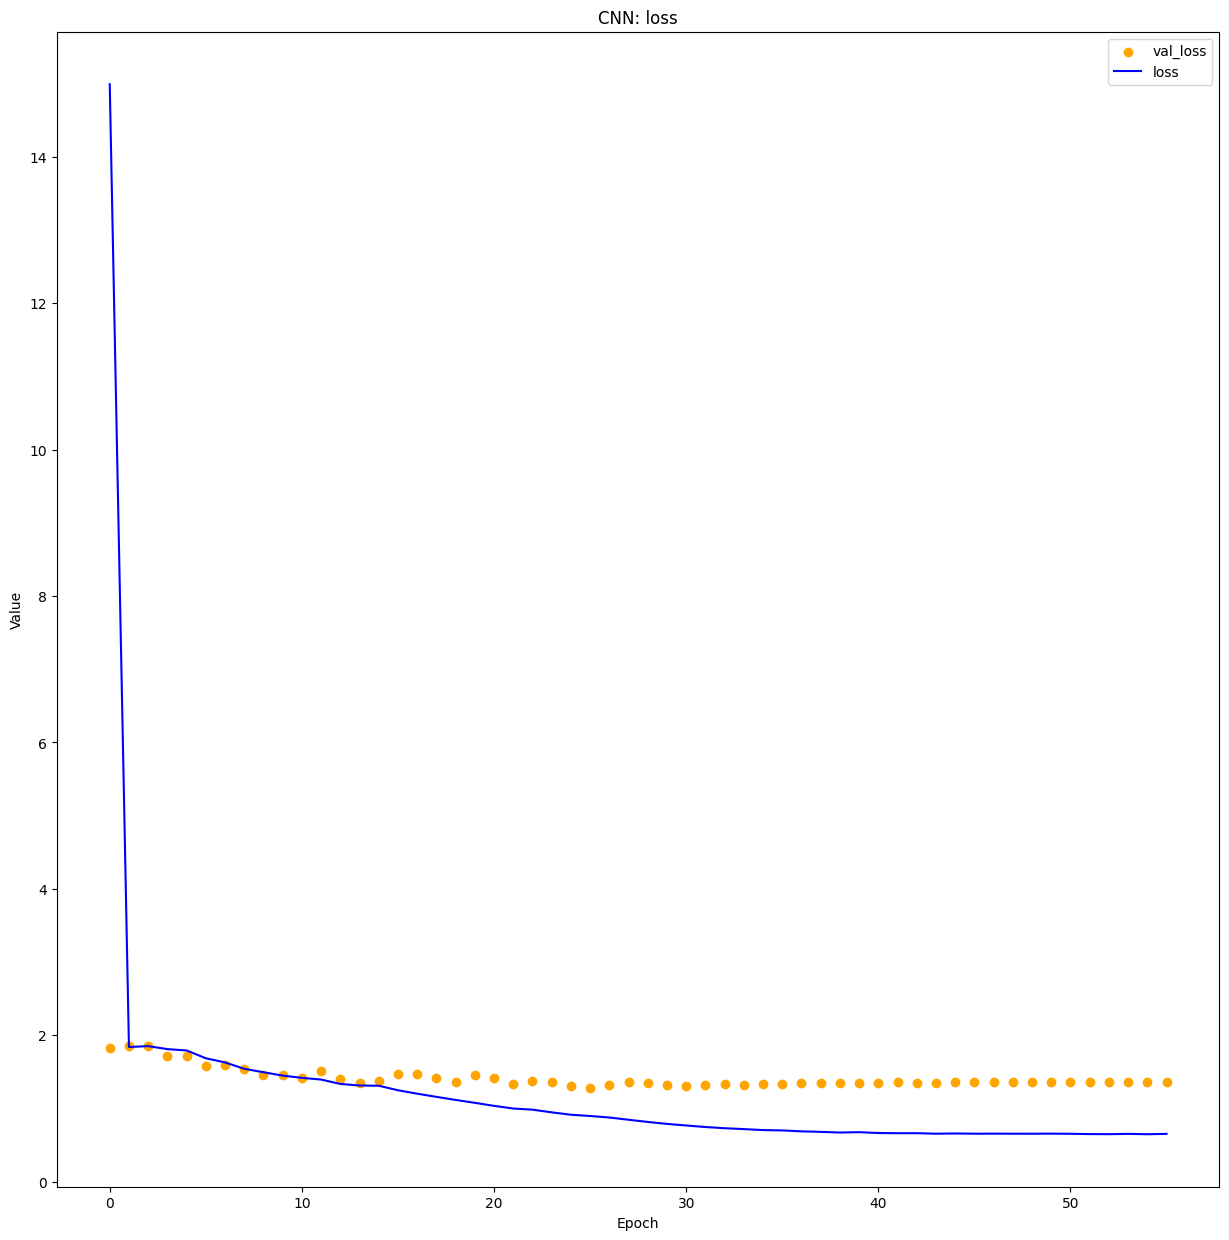

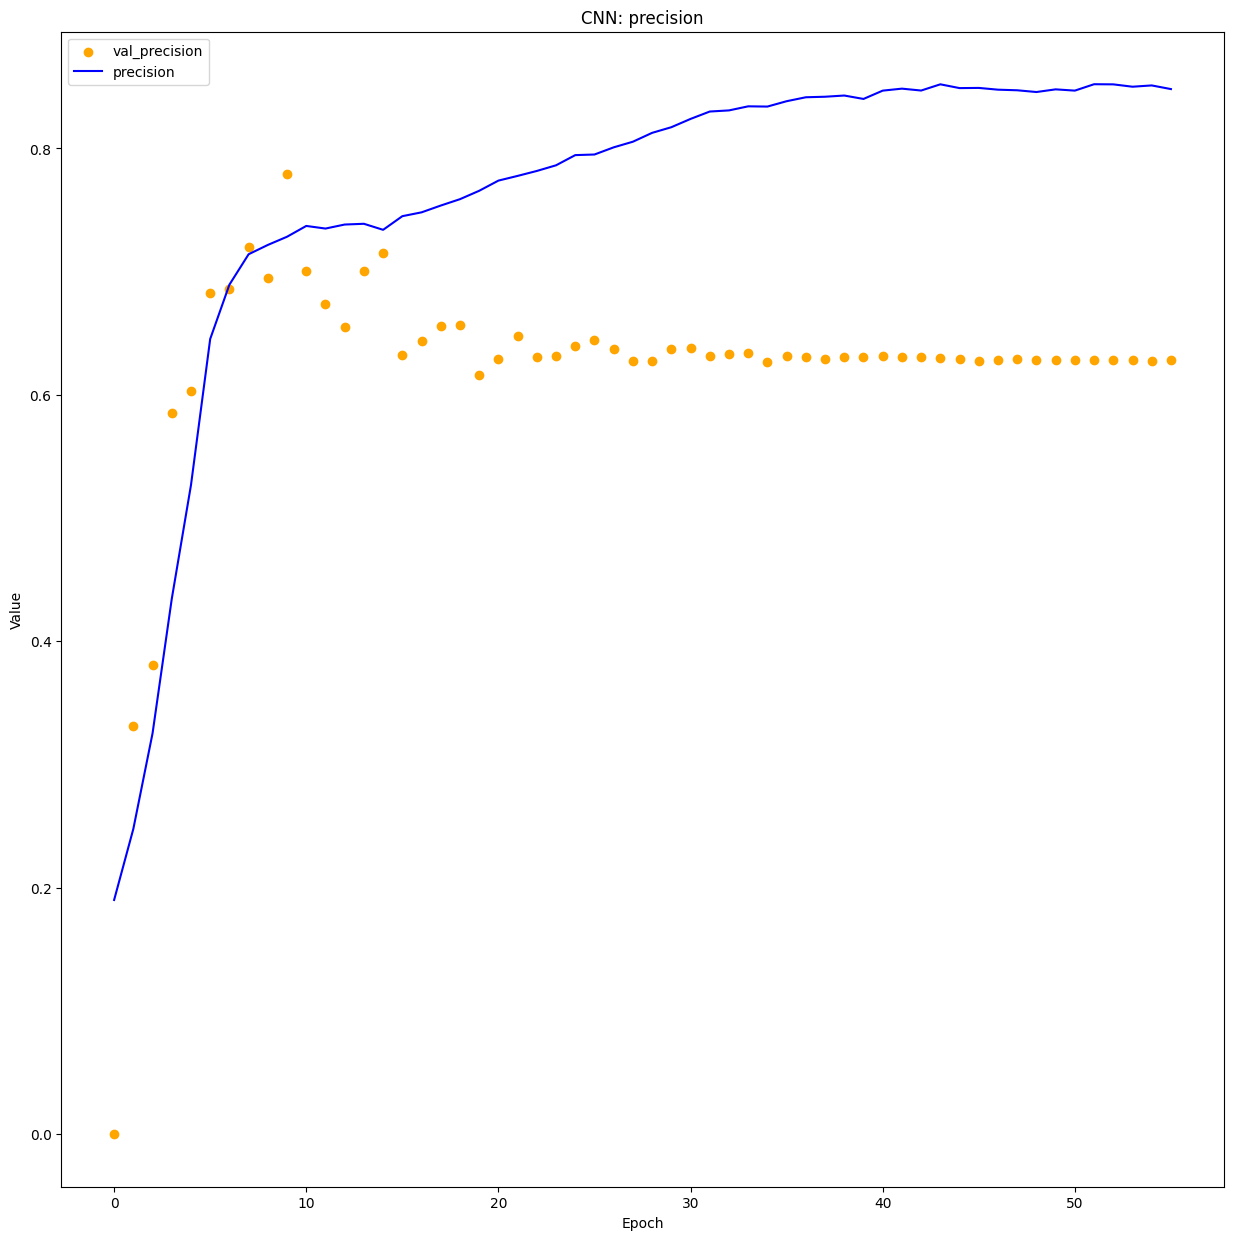

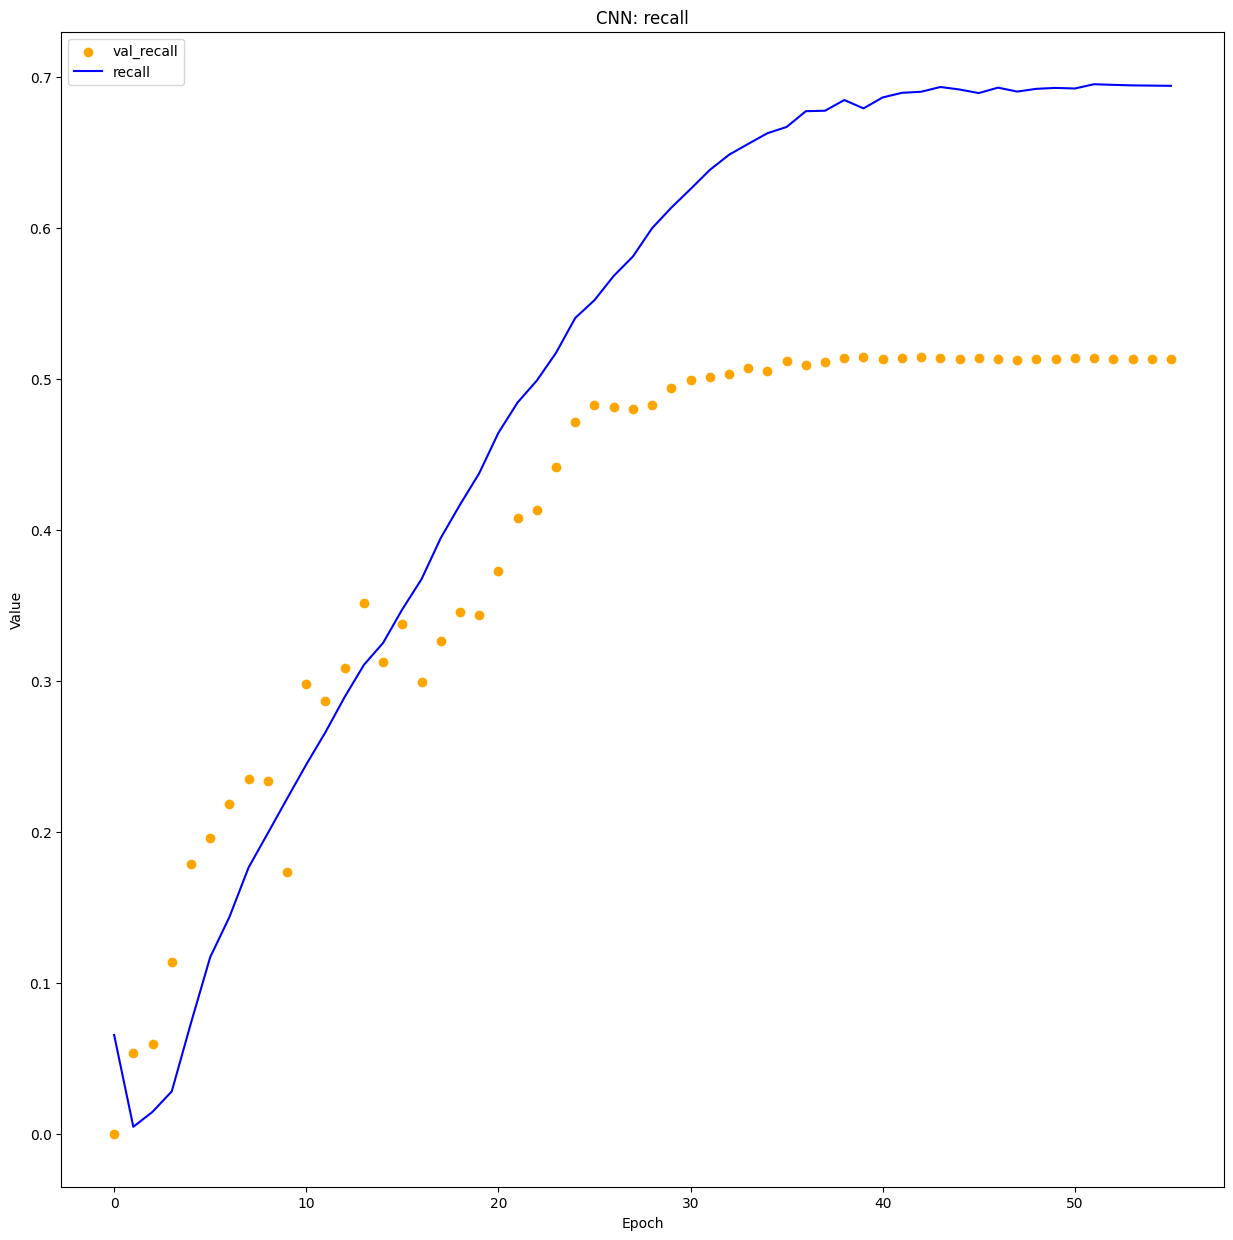

In [9]:
metrics_train = []
metrics_val = []

for metric in history.history.keys():
    if "val" in metric:
        metrics_val.append(metric)
    else:
        metrics_train.append(metric)

# Show result of training
for metric_train, metric_val in zip(metrics_train, metrics_val):
    fig = plt.figure(figsize=(15, 15))
    plt.scatter(
        history.epoch,
        history.history[metric_val],
        label=metric_val,
        color="orange",
    )
    plt.plot(
        history.epoch,
        history.history[metric_train],
        label=metric_train,
        color="blue",
    )
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(f"{cnn._name}: {metric_train}")
    plt.savefig(f"visualize/{cnn._name}/{metric_train}.png")